In [363]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [364]:
# good : 5
np.random.seed(27)

In [365]:
n_regions = 4
rs = np.random.uniform(0,1,size=(n_regions,n_regions))
for ii in range(n_regions):
    rs[ii,ii] *= round(([1,-1][ii % 2]))
    
rs

array([[ 0.42572141,  0.81458374,  0.73539729,  0.8680032 ],
       [ 0.38338077, -0.97945663,  0.89319435,  0.20971517],
       [ 0.74182765,  0.66314332,  0.88680146,  0.85801271],
       [ 0.74926221,  0.87014472,  0.18675584, -0.32556672]])

In [425]:
rs

array([[0.1 , 0.1 , 0.1 , 0.  ],
       [0.9 , 0.9 , 1.  , 0.2 ],
       [0.1 , 0.  , 0.05, 0.9 ],
       [0.  , 0.1 , 0.1 , 0.9 ]])

In [428]:
rs = np.zeros((n_regions,n_regions))

# 0 -> 1
# 1 -> 3
# 2 -> 0
# 3 -> 2

reordr = [1,3,0,2]

rs[0,:] = [1,0.9,0.2,0.9]
rs[1,:] = [0.1,0,0.9,0.1]
rs[2,:] = [0.1,0.1,0.0,0.1]
rs[3,:] = [0.05,0.1,0.9,0.0]

rs[0,:] = [0,0.1,0.1,0.1]
rs[1,:] = [0.2,1,0.9,0.9]
rs[2,:] = [0.9,0.05,0.0,0.1]
rs[3,:] = [0.05,0.1,0.9,0.0]


x0 = np.array([1000,200,200,100])
x0 = np.array([200,1000,100,200])

In [427]:
rs

array([[0.1 , 0.1 , 0.1 , 0.  ],
       [0.9 , 0.9 , 1.  , 0.2 ],
       [0.1 , 0.  , 0.05, 0.9 ],
       [0.  , 0.1 , 0.1 , 0.9 ]])

In [367]:
#x0 = np.random.randint(100,1000,size = 4)

In [699]:
def f(y,t):
    x_new = np.zeros(n_regions)
    for ii in range(n_regions):
        for jj in range(n_regions):
            if ii != jj:
                x_new[ii] += y[jj]*rs[jj,ii] - y[ii]*rs[ii,jj]
            else:
                x_new[ii] += rs[ii,ii]
    return x_new
    

In [430]:
time = np.linspace(0,5,500)


In [431]:
soln = odeint(f,x0,time)
int_soln = soln.round()

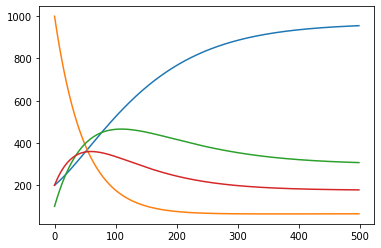

In [432]:
plt.plot(soln)
plt.show()

In [473]:
def model(y,t,p):
    x_new = np.zeros(n_regions)
    print()
    for ii in range(n_regions):
        for jj in range(n_regions):
            k = int(ii*n_regions + jj)
            if ii != jj:
                x_new[ii] += y[jj]*p[k] - y[ii]*p[k]
            else:
                print(p[k])
                x_new[ii] += p[k]
    return x_new
    

In [565]:
from scipy.optimize import leastsq,minimize
from scipy import integrate
class ODE_solver:
    def __init__(self,
                 time,
                 y,
                 y0,
                 n_regions,
                ):
        self.n_regions = n_regions
        self.time = time
        self.y = y
        self.N = self.y.shape[0]
        self.y0 = y0
    def ode(self, y, t, p):
        x_new = np.zeros(self.n_regions)
        rs = p.reshape(n_regions,n_regions)
        for ii in range(self.n_regions):
            for jj in range(self.n_regions):
                if ii != jj:
                    x_new[ii] += y[jj]*rs[jj,ii] - y[ii]*rs[ii,jj]
                else:
                    x_new[ii] += rs[ii,ii]
        return x_new

    def model(self,t, p):
        y_new = integrate.odeint(self.ode, self.y0, t, args=(p,))
        return y_new

    def min_fun(self, p):
        return np.mean((self.y.flatten() - self.model(self.time, p).flatten())**2)

    def optim(self, p_guess):
        return minimize(self.min_fun, p_guess)


In [566]:
odes = ODE_solver(time,int_soln,x0,n_regions)
prms = odes.optim(np.random.random(n_regions*n_regions))

In [567]:
pred_r = prms["x"].reshape(n_regions,n_regions)

(-0.5, 3.5, 3.5, -0.5)

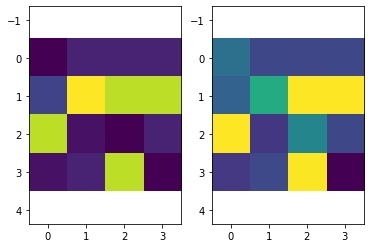

In [568]:
plt.subplot(121)
plt.imshow(rs)
plt.axis("equal")
plt.subplot(122)
plt.imshow(pred_r)
plt.axis("equal")

## spatial

In [642]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    
import preprocess as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
TEST_PTH = "/home/alma/w-projects/ccf/rsc/ref/soft/soft_1.png"

In [433]:
from PIL import Image
img = Image.open(TEST_PTH)

In [434]:
crd,meta = pp.reference_to_grid(img,n_approx_points=1000,
                           background_color="white",
                           n_regions=4,
                           )

[0 2 3 4]


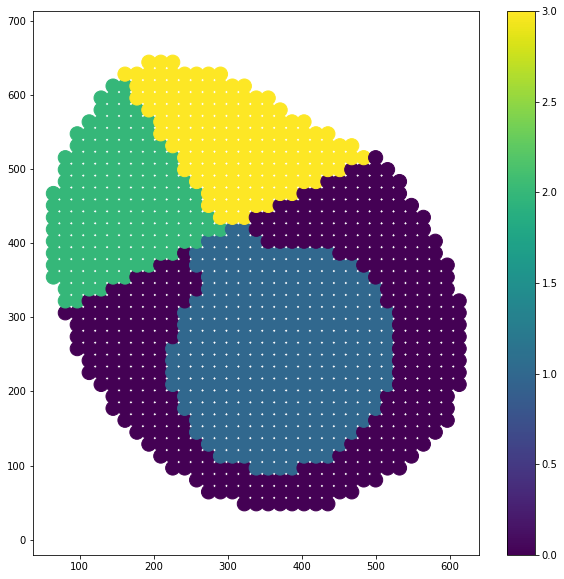

In [435]:
plt.figure(figsize=(10,10))
sc = plt.scatter(crd[:,0],crd[:,1],s = 200,c = meta)
plt.axis("equal")
plt.colorbar(sc)
plt.show()

In [436]:
regions,n_obs = np.unique(meta,return_counts=True)
scalef = n_obs / n_obs.sum()
counts = np.zeros((crd.shape[0],time.shape[0]))
for t in range(time.shape[0]):
    for k,reg in enumerate(regions):
        idx = np.where(meta == reg)[0]
        sel = np.random.choice(idx,replace = True,
                               size = int(int_soln[t,k]))
        for s in sel:
            counts[s,t] +=1

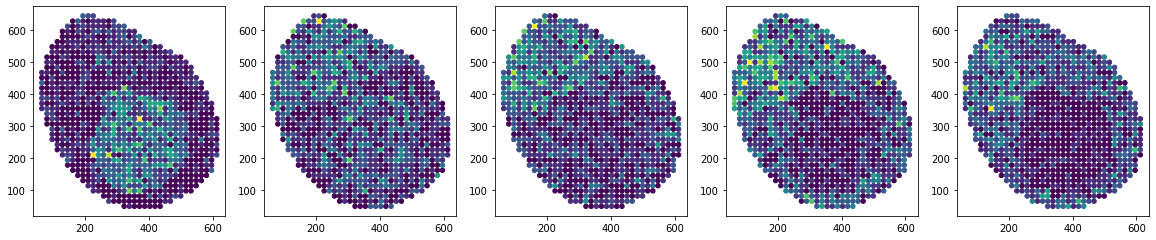

In [437]:
sel_times = np.linspace(0,150-1,5).round().astype(int)
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

for k in range(len(ax)):
    ax[k].scatter(crd[:,0],
                  crd[:,1],
                  c = counts[:,sel_times[k]],
                  s = 20)
    ax[k].set_aspect("equal")

## generate time series data

In [587]:
import os.path as osp

DIR = "/home/alma/w-projects/ccf/rsc/ref/soft"
LMK_DIR = osp.join(DIR,"landmarks")
img_paths = [osp.join(DIR,"soft_{}.png".format(x)) for x in range(0,6)]
lmk_paths = [osp.join(LMK_DIR,"soft_{}_landmarks.tsv".format(x)) for x in range(0,6)]

ref_img_pth = img_paths.pop(0)
ref_lmk_pth = lmk_paths.pop(0)

[1 2 3 4]


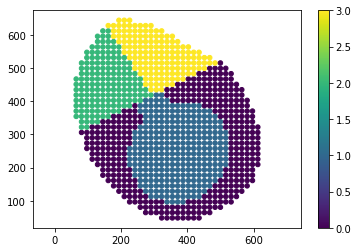

[0 2 3 4]


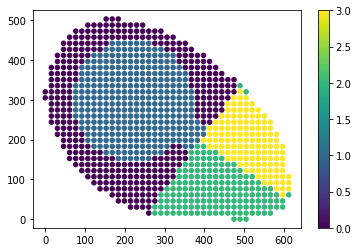

[0 2 3 4]


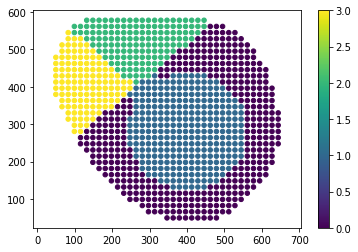

[1 2 3 4]


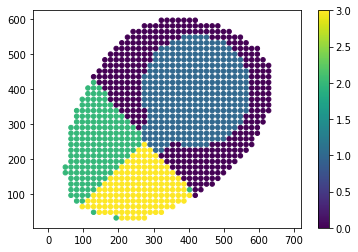

[0 2 3 4]


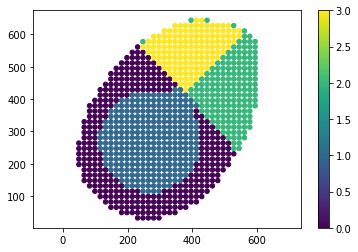

In [588]:
from PIL import Image
sel_times = np.linspace(0,150-1,5).round().astype(int)
new_int_soln = int_soln
crds = list()
counts = list()
lmks = list()
for ii,(img_pth,lmk_pth,t) in enumerate(zip(img_paths,lmk_paths,sel_times)):
    lmk = pd.read_csv(lmk_pth,sep = "\t",header = 0,index_col = 0)
    lmks.append(lmk)
    img = Image.open(img_pth)
    crd,meta = pp.reference_to_grid(img,n_approx_points=1000,
                               background_color="white",
                               n_regions=4,
                               )
    
    count = np.zeros(crd.shape[0])

    for k,reg in enumerate(np.unique(meta)):
        idx = np.where(meta == reg)[0]
        sel = np.random.choice(idx,replace = True,
                               size = int(new_int_soln[t,k]))
        for s in sel:
            count[s] +=1
            
    crds.append(crd)
    counts.append(count)
    sc = plt.scatter(crd[:,0],crd[:,1],c = meta,s = 20)
    plt.axis("equal")
    plt.colorbar(sc)
    plt.show()

In [590]:
ref_lmk = pd.read_csv(ref_lmk_pth,sep = "\t",header = 0,index_col = 0)
ref_img = Image.open(ref_img_pth)
ref_crd,ref_meta = pp.reference_to_grid(ref_img,n_approx_points=1000,
                           background_color="white",
                           n_regions=4,
                           )



[1 2 3 4]


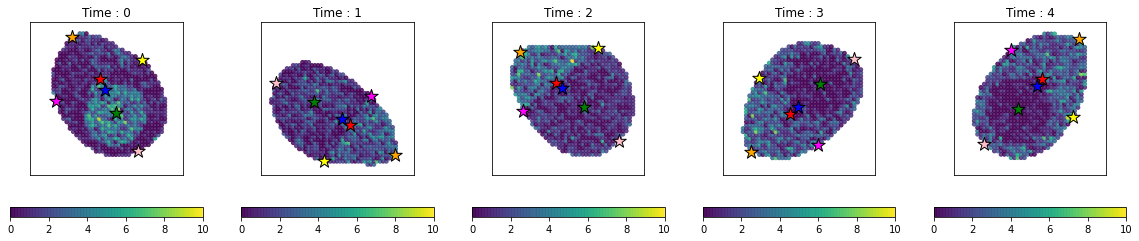

In [1241]:
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

cmap = {0:"orange",1:"red",2:"blue",3:"green",4:"pink",5:"magenta",6:"yellow"}

vmin = min([c.min() for c in counts])
vmax = max([c.max() for c in counts])

for k in range(len(sel_times)):
    sc = ax[k].scatter(crds[k][:,0],
                  crds[k][:,1],
                  c = counts[k],
                  s = 14,
                  cmap = plt.cm.viridis,
                  vmin = vmin,
                  vmax = vmax,
                  alpha = 0.8)


    fig.colorbar(sc,ax = ax[k],orientation = "horizontal")
    
    for l in range(lmks[k].shape[0]):
        ax[k].scatter(lmks[k].values[l,0],
                      lmks[k].values[l,1],
                      s = 200,
                      marker = "*",
                      c = cmap[l],
                      edgecolor = "black",
                     )
        
    ax[k].set_aspect("equal")
    ax[k].set_xlim([-50,700])
    ax[k].set_ylim([-50,700])
    ax[k].set_yticks([])
    ax[k].set_xticks([])
    ax[k].set_title(f"Time : {k}")

In [592]:
import utils as ut
import preprocess as pp

In [601]:
lmks[k]

,x_cord,y_cord
Landmark_0,154.539,628.551
Landmark_1,293.832,418.572
Landmark_2,315.315,365.904
Landmark_3,370.755,252.252
Landmark_4,480.249,66.528
Landmark_5,76.230,311.157
Landmark_6,498.960,515.592


In [602]:
adatas = []
for k in range(len(crds)):
    obs_index = [f"Spot_{x}" for x in range(len(crds[k]))]
    adata = ad.AnnData(counts[k][:,np.newaxis],
                       var = pd.DataFrame(["Gene1"],
                                          columns = ["Gene"],
                                          index = ["Gene1"],
                                         ),
                       obs = pd.DataFrame(index = obs_index)
                      )
    adata.obsm["spatial"] = crds[k]
    adata.uns["curated_landmarks"] = lmks[k]
    pp.get_landmark_distance(adata)
    adatas.append(adata)

In [617]:
import models as m
import methods as f

ref = m.Reference(ref_crd,
                  landmarks = ref_lmk.values,
                 )

models = f.map_to_reference(adatas,
                           "Gene1",
                            ref,
                            n_epochs=1000,
                           )

/home/alma/w-projects/ccf/src/models.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = t.tensor(landmarks)


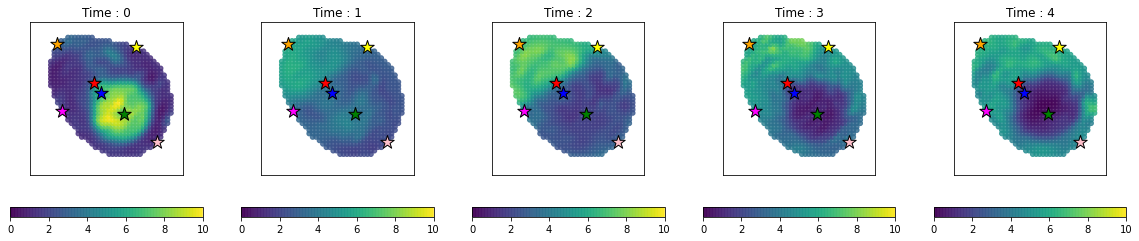

In [1243]:
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

cmap = {0:"orange",1:"red",2:"blue",3:"green",4:"pink",5:"magenta",6:"yellow"}

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

for k in range(len(sel_times)):
    ax[k].scatter(ref_crd[:,0],ref_crd[:,1],
                  c = ref.adata.X[:,k],
                  s = 22,
                  cmap = plt.cm.viridis,
                  alpha = 0.8,
                  marker = "o",
                  vmin = vmin,
                  vmax = vmax,
                 )
    

    fig.colorbar(sc,ax = ax[k],orientation ="horizontal")
    
    for l in range(ref_lmk.shape[0]):
        ax[k].scatter(ref_lmk.values[l,0],
                      ref_lmk.values[l,1],
                      s = 200,
                      marker = "*",
                      c = cmap[l],
                      edgecolor = "black",
                     )
        
    ax[k].set_aspect("equal")
    ax[k].set_xlim([-50,700])
    ax[k].set_ylim([-50,700])
    ax[k].set_yticks([])
    ax[k].set_xticks([])
    ax[k].set_title(f"Time : {k}")

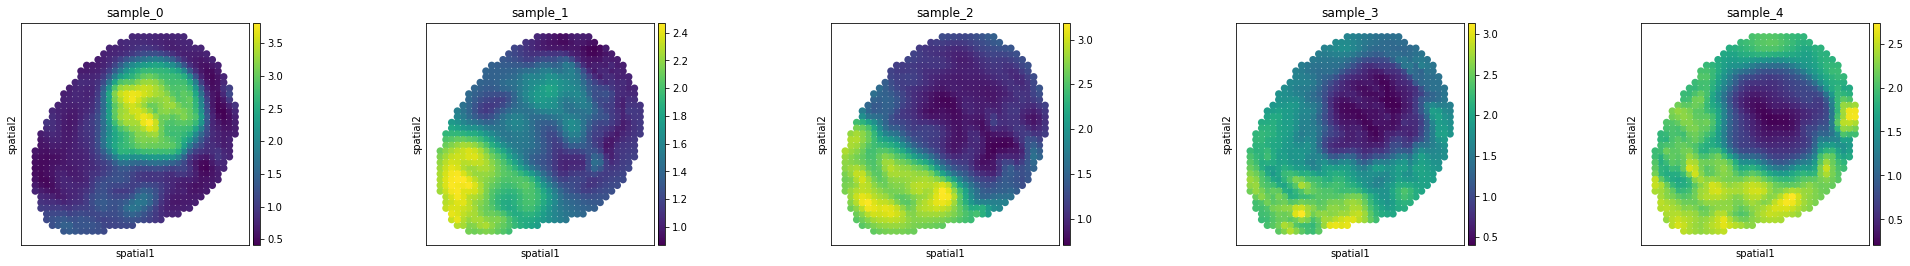

In [1087]:
ref.plot(spot_size=22,ncols = 5,cmap = plt.cm.viridis,alpha = 1,hspace = 0.01)

## Optical flow stuff

In [805]:
from scipy.spatial.distance import cdist

In [829]:
dmat = cdist(ref.adata.obsm["spatial"],ref.adata.obsm["spatial"])
dmat[dmat == 0] = np.inf
radius = np.floor(dmat.min())

In [953]:
import squidpy as sq
sq.gr.spatial_neighbors(ref.adata,n_neigh=4,coord_type="generic",key_added="spatial_4")
sq.gr.spatial_neighbors(ref.adata,n_neigh=9,coord_type="generic",key_added="spatial_9")

In [951]:
ref.adata

AnnData object with n_obs × n_vars = 959 × 5
    uns: 'spatial_neighbors', 'spatial_connectivities_4_neighbors', 'spatial_connectivities_9_neighbors', 'spatial_4_neighbors', 'spatial__9_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_distances', 'spatial_connectivities_4_distances', 'spatial_connectivities_9_distances', 'spatial_connectivities', 'spatial_connectivities_4_connectivities', 'spatial_connectivities_9_connectivities', 'spatial_4_connectivities', 'spatial_4_distances', 'spatial__9_connectivities', 'spatial__9_distances'

In [908]:
ref.adata.obsp["spatial_connectivities"]

<959x959 sparse matrix of type '<class 'numpy.float64'>'
	with 3836 stored elements in Compressed Sparse Row format>

In [1120]:
crd = ref.adata.obsm["spatial"]
ori_vals = np.array(ref.adata.X)
new_vals = np.zeros(ori_vals.shape)
n_obs,n_features = ref.adata.shape
gr4 = ref.adata.obsp["spatial_4_connectivities"]
for s in range(n_obs):
    ptr = slice(gr4.indptr[s],gr4.indptr[s+1])
    idx = np.append(gr4.indices[ptr],s)
    for g in range(n_features):
        new_vals[s,g] = ori_vals[idx,g].mean()
        

In [1115]:
crd = ref.adata.obsm["spatial"]
vals = new_vals[:,[0,1]]
n_obs = ref.adata.shape[0]
gr4 = ref.adata.obsp["spatial_4_connectivities"]
gr9 = ref.adata.obsp["spatial_9_connectivities"]
satind = np.zeros(n_obs)
dx = np.zeros(n_obs)
dy = np.zeros(n_obs)
dt = np.zeros(n_obs)
flow_vectors = np.zeros((n_obs,2))
for s in range(n_obs):
    ptr = slice(gr4.indptr[s],gr4.indptr[s+1])
    idx = gr4.indices[ptr]
    nbrs = crd[idx,:]
    nbrs_vals = vals[idx,:]
    center = crd[s,:]
    on_x = nbrs[:,1] == center[1]
    on_y = nbrs[:,0] == center[0]
    if sum(on_x) == 2 and sum(on_y) == 2:
        satind[s] = 1
        xvals = nbrs_vals[on_x,:][np.argsort(nbrs[on_x,0]),:].mean(axis=1)
        yvals = nbrs_vals[on_y,:][np.argsort(nbrs[on_y,1]),:].mean(axis=1)
        dx[s] = np.diff(xvals)[0]
        dy[s] = np.diff(yvals)[0]
        dt[s] = vals[s,1] - vals[s,0]
for s in range(n_obs):
    if satind[s] == 1:
        ptr = slice(gr9.indptr[s],gr9.indptr[s+1])
        idx = np.append(gr9.indices[ptr],s)
        A = np.hstack((dx[idx,np.newaxis],dy[idx,np.newaxis]))
        b = -dt[idx]
        v = -np.dot(np.linalg.inv(np.dot(A.T,A)),np.dot(A.T,b))
        flow_vectors[s,:] = v

norm = np.linalg.norm(flow_vectors,axis=1,keepdims=True)
flow_vectors = np.divide(flow_vectors, norm,where = norm.flatten()[:,np.newaxis] > 0)

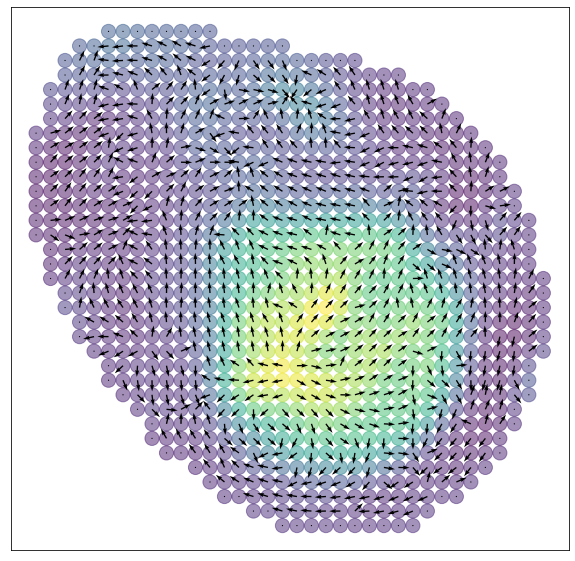

In [1122]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(crd[:,0],crd[:,1],c = ori_vals[:,0], alpha = 0.5,s = 200)
ax.quiver(crd[:,0],crd[:,1],flow_vectors[:,0],flow_vectors[:,1])
ax.set_xticks([])
ax.set_yticks([])

plt.axis("equal")
plt.show()

# import matplotlib.patches as patches

help(patches.Rectangle)

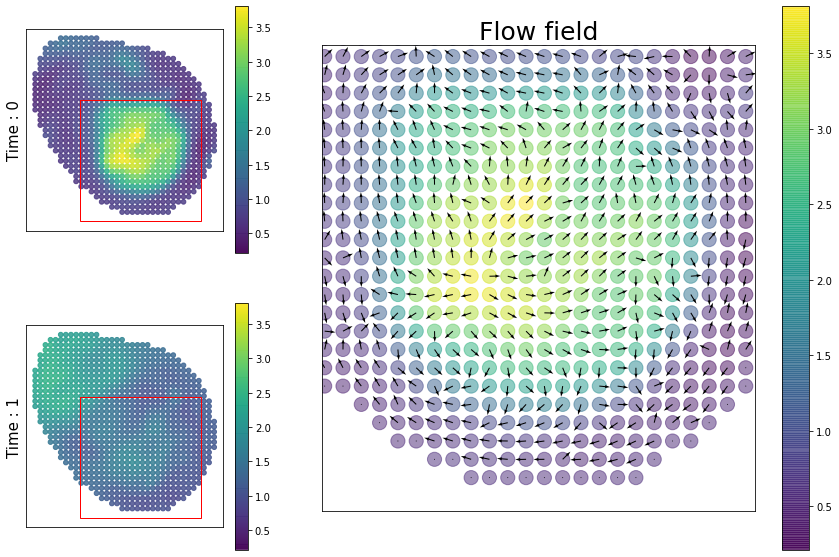

In [1211]:
import matplotlib.patches as patches
mosaic = """
    ABB
    CBB
    """
axd = plt.figure(constrained_layout=True,figsize = (15,10)).subplot_mosaic(mosaic)

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

for t,l in zip([0,1],["A","C"]):
    sc = axd[l].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,t],
                    s = 22,
                    cmap = plt.cm.viridis,
                    alpha = 0.8,
                    marker = "o",
                        vmin = vmin,
                        vmax = vmax,
                    )
    rect = patches.Rectangle((200,20),400,400,
                          linewidth=1,
                           edgecolor='r',
                          facecolor='none')
    axd[l].add_patch(rect)
    axd[l].set_xticks([])
    axd[l].set_yticks([])
    axd[l].set_aspect("equal")
    axd[l].set_ylabel(f"Time : {t}",fontsize = 15)
    fig.colorbar(sc, ax=axd[l])

    
axd["B"].scatter(ref_crd[:,0],ref_crd[:,1],
                 c = ori_vals[:,0],
                 alpha = 0.5,
                 s = 200)
axd["B"].quiver(ref_crd[:,0],
                ref_crd[:,1],
                flow_vectors[:,0],
                flow_vectors[:,1],
                scale = 40,
               )

axd["B"].set_xticks([])
axd["B"].set_yticks([])
axd["B"].set_xlim([200,600])
axd["B"].set_ylim([20,450])
axd["B"].set_title("Flow field",fontsize = 25)
axd["B"].set_aspect("equal")
fig.colorbar(sc, ax=axd["B"])


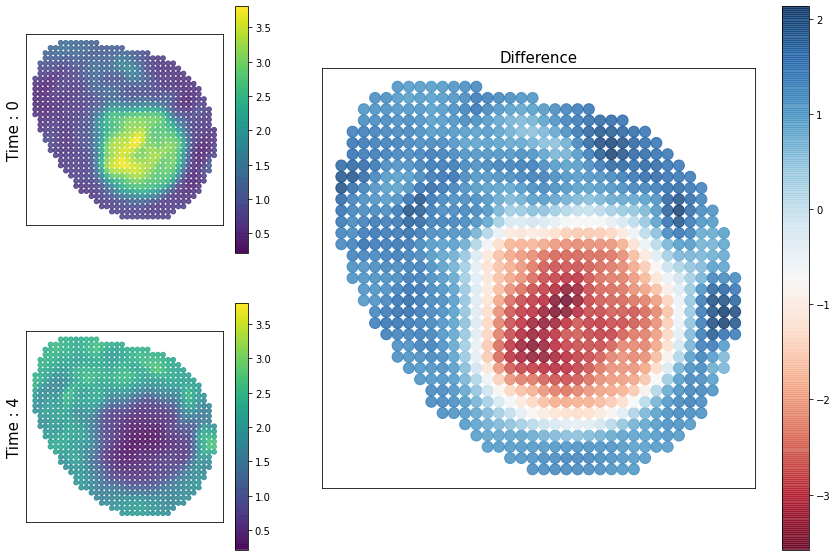

In [1210]:
import matplotlib.patches as patches
mosaic = """
    ABB
    CBB
    """
axd = plt.figure(constrained_layout=True,figsize = (15,10)).subplot_mosaic(mosaic)

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

timepoints = [0,4]
for t,l in zip(timepoints,["A","C"]):
    sc = axd[l].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,t],
                    s = 22,
                    cmap = plt.cm.viridis,
                    alpha = 0.8,
                    marker = "o",
                    vmin = vmin,
                    vmax = vmax,
                    )
    
    axd[l].set_xticks([])
    axd[l].set_yticks([])
    axd[l].set_aspect("equal")
    axd[l].set_ylabel(f"Time : {t}",fontsize = 15)
    fig.colorbar(sc, ax=axd[l])
    
sc = axd["B"].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,timepoints[1]] - ref.adata.X[:,timepoints[0]],
                    s = 120,
                    cmap = plt.cm.RdBu,
                    alpha = 0.8,
                    marker = "o",
                    )
    
axd["B"].set_xticks([])
axd["B"].set_yticks([])
axd["B"].set_aspect("equal")
axd["B"].set_title(f"Difference",fontsize = 15)
fig.colorbar(sc, ax=axd["B"])
plt.show()

In [ ]:
def spatial_derivatives(graph):
    
    

## ODE stuff

In [632]:
ref.adata

AnnData object with n_obs × n_vars = 959 × 5
    obsm: 'spatial'

In [639]:
time_data = np.zeros((len(adatas),n_regions))

for t in range(len(adatas)):
    for reg in range(n_regions):
        idx = ref_meta == reg
        time_data[t,reg] = np.sum(ref.adata.X[idx,t])

In [650]:
import ode

In [640]:
time_data

array([[307.74111938, 775.56134033, 195.70913696,  95.88406372],
       [428.44836426, 417.74865723, 326.92651367, 292.16442871],
       [458.05859375, 286.67666626, 459.9473877 , 349.31167603],
       [592.03100586, 226.94122314, 408.12731934, 286.31689453],
       [671.78607178, 219.8555603 , 390.27801514, 281.55633545]])

In [730]:
p = np.random.random(n_regions**2)
p

array([0.02791328, 0.34633798, 0.25470035, 0.94406199, 0.5858264 ,
       0.80824838, 0.86239702, 0.26155701, 0.64777413, 0.59537506,
       0.45040041, 0.23172572, 0.51689587, 0.641825  , 0.54118164,
       0.2470281 ])

In [745]:
sode = ode.ODESolver(np.arange(5),
                     time_data,
                     time_data[0,:],
                     n_regions = n_regions,
                    )

fitted_res = sode.optim(p)

In [746]:
fitted_res["x"].reshape(n_regions,n_regions)

array([[  5.12234998,   0.15063399,   0.3583526 ,   0.26559534],
       [  1.49593892,   0.91597993,  -0.63815759,  -0.07109989],
       [  9.71429482,   0.70416961,  25.52667749,  -3.50784568],
       [-12.73208886,  -0.71819994,   9.20653101,  22.10342311]])

(-0.5, 3.5, 3.5, -0.5)

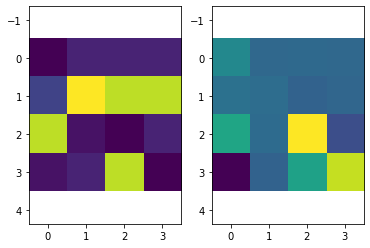

In [747]:
plt.subplot(121)
plt.imshow(rs)
plt.axis("equal")
plt.subplot(122)
plt.imshow(fitted_res["x"].reshape(n_regions,n_regions))
plt.axis("equal")

In [748]:
def f(y,t):
    x_new = np.zeros(n_regions)
    for ii in range(n_regions):
        for jj in range(n_regions):
            if ii != jj:
                x_new[ii] += y[jj]*pred_soln[jj,ii] - y[ii]*pred_soln[ii,jj]
            else:
                x_new[ii] += pred_soln[ii,ii]
    return x_new

In [749]:
pred_soln = odeint(f,time_data[0,:],sel_times)

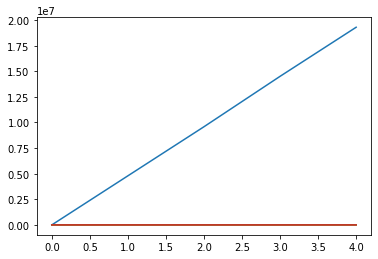

In [750]:
plt.plot(pred_soln)

In [797]:
from scipy.interpolate import griddata
def makeimg(crd,vals):
    mn_x,mn_y = crd.min(axis=0)
    mx_x,mx_y = crd.max(axis=0)
    n_space = int(np.ceil(np.sqrt(crd.shape[0])))
    xx = np.linspace(mn_x,mx_x,200)
    yy = np.linspace(mn_y,mx_y,200)
    xx,yy = np.meshgrid(xx,yy)
    return griddata(crd,vals,(yy,xx),fill_value=np.nan)
    